In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import face_alignment
import torch

from preprocess import calibrate, normalize, undistort_image
from eve import EVE

# Pipeline for preprocessing as per EVE dataset

### Preprocessing steps:

1) intrinsic matrix calibration using opencv and ChArUco board [5]
2) extrinsic camera calibration using mirrors [1]
3) undistort the frames
4) detect face 
5) detect face-region landmarks (use face_alignment and blazeface)
6) perform 3D morphable model (3DMM) to 3D landmarks [2]
7) apply 'data normalization' for yielding eye patches [3, 4] under assumptions:
   - virtual camera is located 60cm away from the gaze origin
   - focal length of 1800mm


[1] https://www.jstage.jst.go.jp/article/ipsjtcva/8/0/8_11/_pdf/-char/en

[2] https://openresearch.surrey.ac.uk/discovery/delivery/44SUR_INST:ResearchRepository/12139198320002346#13140605970002346

[3] https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Sugano_Learning-by-Synthesis_for_Appearance-based_2014_CVPR_paper.pdf

[4] https://www.perceptualui.org/publications/zhang18_etra.pdf

[5] https://docs.opencv.org/4.5.2/dc/dbb/tutorial_py_calibration.html

In [2]:
np.set_printoptions(suppress=True)

In [3]:
images = [cv2.resize(cv2.imread(i), (1920, 1080))
          for i in glob.glob('./data/*.jpg')]

In [4]:
ret, mtx, dist, rvecs, tvecs = calibrate(images)

In [5]:
img = images[5]

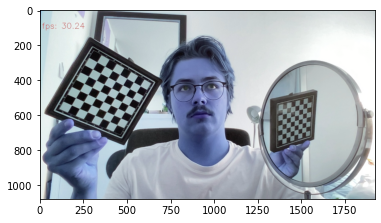

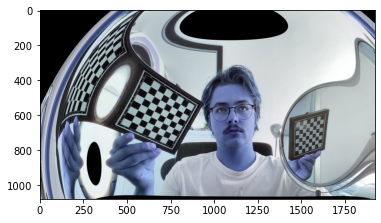

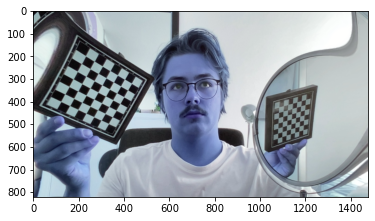

In [6]:
img = undistort_image(img, mtx, dist)

In [7]:
fa2d = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D,
                                    flip_input=False,
                                    device='cpu',
                                    face_detector='blazeface')

landmark indices:
- corner left left: 36
- corner left right: 39
- corner right left: 42
- corner right right: 45
- mouth left: 48
- mouth right: 54

In [9]:
[preds] = fa2d.get_landmarks(img)

landmarks = [preds[36], preds[39], preds[42], preds[45], preds[48], preds[54]]

In [120]:
i['pixels_per_millimeter']

tensor([[[3.4720, 3.4727]]])

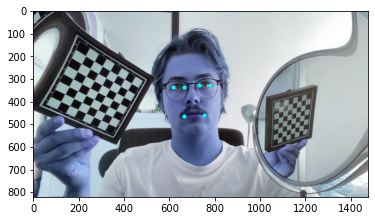

In [10]:
_img = img.copy()
plt.imshow(_img)
for i in landmarks:
    plt.scatter(i[0], i[1], color='cyan', marker='.')

In [11]:
fa3d = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D,
                                    flip_input=False,
                                    device='cpu',
                                    face_detector='blazeface')

[preds_3d] = fa3d.get_landmarks(img)

In [12]:
def get_origin_of_gaze(preds_3d):
    """
    :param preds: 3d landmarks predictions
    """
    preds = np.array(preds_3d)
    left_coords = preds[slice(36, 42)]
    right_coords = preds[slice(42, 48)]
    left_o = [
        left_coords[:, 0].mean(), 
        left_coords[:, 1].mean(),
        left_coords[:, 2].mean()
    ]
    right_o = [
        right_coords[:, 0].mean(), 
        right_coords[:, 1].mean(),
        right_coords[:, 2].mean()
    ]
    return left_o, right_o

In [13]:
left_coords = preds[slice(36, 42)]

In [14]:
gc = np.array([-127.790719, 4.621111, -12.025310])  # 3D gaze taraget position

head_R, [
    [left_eye_patch, left_hr_norm, left_gc_normalized, left_R, left_W],
    [right_eye_patch, right_hr_norm, right_gc_normalized, right_R, right_W]
] = head_R, data = normalize(img, mtx, dist, landmarks, gc)

(128, 256, 3)

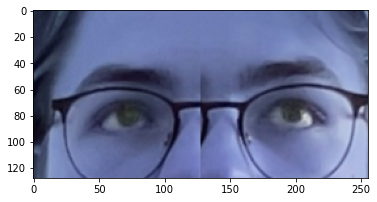

In [16]:
eyes_cat = np.concatenate((left_eye_patch, right_eye_patch), axis=1)
plt.imshow(eyes_cat)
eyes_cat.shape

In [17]:
left_R, right_R

(array([[ 0.97893696, -0.10913434,  0.172546  ],
        [ 0.04973973,  0.94716162,  0.31687666],
        [-0.19801107, -0.30161989,  0.93263983]]),
 array([[ 0.99142359, -0.08521353,  0.09908539],
        [ 0.04973973,  0.94716162,  0.31687666],
        [-0.12085205, -0.30923052,  0.94327688]]))

In [18]:
left_W

array([[   0.64154127,   -0.08247598, -329.15387471],
       [   0.02673854,    0.6238401 , -164.56531163],
       [  -0.00009643,   -0.00014845,    0.86500718]])

In [19]:
left_gc_normalized

array([[-0.15089544],
       [-0.00684271],
       [-0.98852605]])

In [20]:
from utils import get_sample_input

In [21]:
inp = get_sample_input()

In [22]:
inp['left_R'][:, 0], inp['right_R'][:, 0]

(tensor([[[ 0.9993, -0.0105, -0.0354],
          [ 0.0147,  0.9927,  0.1198],
          [ 0.0339, -0.1202,  0.9922]]]),
 tensor([[[ 0.9980, -0.0219,  0.0590],
          [ 0.0147,  0.9926,  0.1205],
          [-0.0613, -0.1194,  0.9910]]]))

In [23]:
left_R, right_R

(array([[ 0.97893696, -0.10913434,  0.172546  ],
        [ 0.04973973,  0.94716162,  0.31687666],
        [-0.19801107, -0.30161989,  0.93263983]]),
 array([[ 0.99142359, -0.08521353,  0.09908539],
        [ 0.04973973,  0.94716162,  0.31687666],
        [-0.12085205, -0.30923052,  0.94327688]]))

left_R as well as right right_R are both there

In [24]:
inp['head_R'][:, 0]

tensor([[[ 0.9995,  0.0270, -0.0140],
         [-0.0178,  0.8929,  0.4499],
         [ 0.0247, -0.4494,  0.8930]]])

In [25]:
head_R

array([[ 0.99321286,  0.05590847, -0.10199242],
       [-0.08030653,  0.9639635 , -0.2536242 ],
       [ 0.08413723,  0.26009347,  0.96191076]])

head_R is also there

In [26]:
inp['left_h'][:, 0]

tensor([[ 0.5864, -0.0606]])

In [27]:
left_hr_norm

array([[-0.05950211],
       [ 0.09408642],
       [ 0.00280207]])

In [28]:
from normalize_data import estimateHeadPose
import scipy.io as sio

In [29]:
face = sio.loadmat('./faceModelGeneric.mat')['model']
face_pts = face.T.reshape(face.shape[1], 1, 3)

In [30]:
estimateHeadPose(np.array(landmarks), face_pts, mtx, dist)

(array([[ 0.26037975],
        [-0.09434052],
        [-0.06904109]]),
 array([[-135.15648918],
        [-258.77921993],
        [ 794.72053567]]))

In [134]:
ret, rvec, tvec = cv2.solvePnP(face_pts, np.array(landmarks), mtx, dist, flags=cv2.SOLVEPNP_SQPNP)

rotation_m, _ = cv2.Rodrigues(rvec)
extrinsic_matrix = np.hstack([rotation_m, tvec])
extrinsic_matrix = np.vstack([extrinsic_matrix, [0, 0, 0, 1]])

extrinsic_matrix

array([[   0.96106481,    0.04613958,    0.2724437 , -123.5035078 ],
       [   0.02884393,    0.96382326,   -0.26497689, -237.66292317],
       [  -0.2748135 ,    0.26251831,    0.92496577,  724.0253216 ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [34]:
np.linalg.inv(inp['camera_transformation'][:, 0].numpy())

array([[[ -0.99982095,   0.0088855 ,  -0.01670884, 271.66882   ],
        [  0.01386724,   0.9447991 ,  -0.32735658, 443.28265   ],
        [  0.01287778,  -0.32752967,  -0.94475317,  -0.67136055],
        [  0.        ,   0.        ,   0.        ,   1.        ]]],
      dtype=float32)

In [35]:
inp['camera_transformation'][:, 0]

tensor([[[-9.9982e-01,  1.3867e-02,  1.2878e-02,  2.6548e+02],
         [ 8.8855e-03,  9.4480e-01, -3.2753e-01, -4.2145e+02],
         [-1.6709e-02, -3.2736e-01, -9.4475e-01,  1.4902e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])

In [36]:
inp['inv_camera_transformation'][:, 0].numpy()

array([[[ -0.9998209 ,   0.0088855 ,  -0.01670884, 271.6688    ],
        [  0.01386724,   0.9447991 ,  -0.32735658, 443.28265   ],
        [  0.01287777,  -0.32752967,  -0.9447531 ,  -0.6713658 ],
        [  0.        ,   0.        ,   0.        ,   1.        ]]],
      dtype=float32)

mm per px and px per mm for now Ill use constant, as it may have a slight impact

The selected origin of gaze
is an average of the 3D eye corner landmarks of the eye in consideration, taken
from the fitted 3DMM found in the previous step.

## Use code from [https://github.com/computer-vision/takahashi2012cvpr] to get extrinsics

todo inquire about the code to get matrix from rvec and tvec

## 3D morphable model

In [37]:
import eos

mm per px and px per mm for now Ill use the defaults, as it may have a slight impact

In [38]:
model = eos.morphablemodel.load_model('eos/share/sfm_shape_3448.bin')

fitting requires a lot of parameters

# assemble input

In [111]:
d = dict(a = 5)

In [ ]:
d.items()

dict_items([('a', 5)])

In [39]:
required_params = [
    'left_o',
    'left_o_validity',
    'right_o',
    'right_o_validity',
    
    'camera_transformation', 
    'inv_camera_transformation', 
    
    'left_R', 
    'left_R_validity',
    
    'right_R',
    'right_R_validity',
    
    'left_h', 
    'left_h_validity',
    
    'right_h',
    'right_h_validity',
    
    'head_R',
    
    'millimeters_per_pixel',
    'pixels_per_millimeter',
    
    'left_eye_patch',
    'right_eye_patch',
    'timestamps',
    
    'screen_timestamps', 
    'screen_frame'
]    

In [ ]:
left_o, right_o = get_origin_of_gaze(preds_3d)

In [ ]:
i = {}

In [ ]:
inp['left_o'].shape

torch.Size([1, 30, 3])

In [ ]:
i['left_o'] = torch.Tensor([left_o]).unsqueeze(0)

In [ ]:
i['right_o'] = torch.Tensor([right_o]).unsqueeze(0)

In [ ]:
i['left_o_validity'] = torch.Tensor([True]).unsqueeze(0)

In [ ]:
i['right_o_validity'] = torch.Tensor([True]).unsqueeze(0)

In [ ]:
i['camera_transformation'] = torch.Tensor([extrinsic_matrix]).unsqueeze(0)

In [ ]:
i['inv_camera_transformation'] = torch.Tensor([np.linalg.inv(extrinsic_matrix)]).unsqueeze(0)

In [ ]:
inp['left_R'].shape

torch.Size([1, 30, 3, 3])

In [ ]:
i['left_R'] = torch.Tensor([left_R]).unsqueeze(0)

In [ ]:
i['left_R_validity'] = torch.Tensor([True]).unsqueeze(0)

In [ ]:
i['right_R'] = torch.Tensor([right_R]).unsqueeze(0)

In [ ]:
i['right_R_validity'] = torch.Tensor([True]).unsqueeze(0)

In [ ]:
# todo left_h, right_h can be disabled for now 

In [ ]:
i['head_R'] = torch.Tensor([head_R]).unsqueeze(0)

In [ ]:
i['millimeters_per_pixel'] = inp['millimeters_per_pixel'][:, 0].unsqueeze(0)

In [ ]:
i['pixels_per_millimeter'] = inp['pixels_per_millimeter'][:, 0].unsqueeze(0)

In [ ]:
from preprocess import preprocess_frames

In [ ]:
_left_eye_patch = preprocess_frames(np.expand_dims(left_eye_patch, axis=0))
i['left_eye_patch'] = torch.from_numpy(_left_eye_patch)

In [ ]:
_right_eye_patch = preprocess_frames(np.expand_dims(right_eye_patch, axis=0))
i['right_eye_patch'] = torch.from_numpy(_right_eye_patch)

In [ ]:
i['timestamps'] = torch.Tensor([925789010258708]).unsqueeze(0)

In [ ]:
cap = cv2.VideoCapture('./data/scene.mp4')
ret, frame = cap.read()
screen_frame = cv2.resize(frame, dsize=(128, 72))

In [ ]:
_screen_frame = preprocess_frames(np.expand_dims(screen_frame, axis=0))
i['screen_frame'] = torch.from_numpy(_screen_frame)

In [ ]:
i['screen_timestamps'] = torch.Tensor([925789010258708]).unsqueeze(0)

In [69]:
from eve import EVE

In [70]:
eve = EVE().eval()

In [105]:
out = eve(i)

In [83]:
x, y = [1442, 884]

In [102]:
frame = cv2.resize(frame, (1920, 1080))

In [103]:
frame = cv2.circle(frame, (x, y), 25, (255, 255, 255), thickness=5)

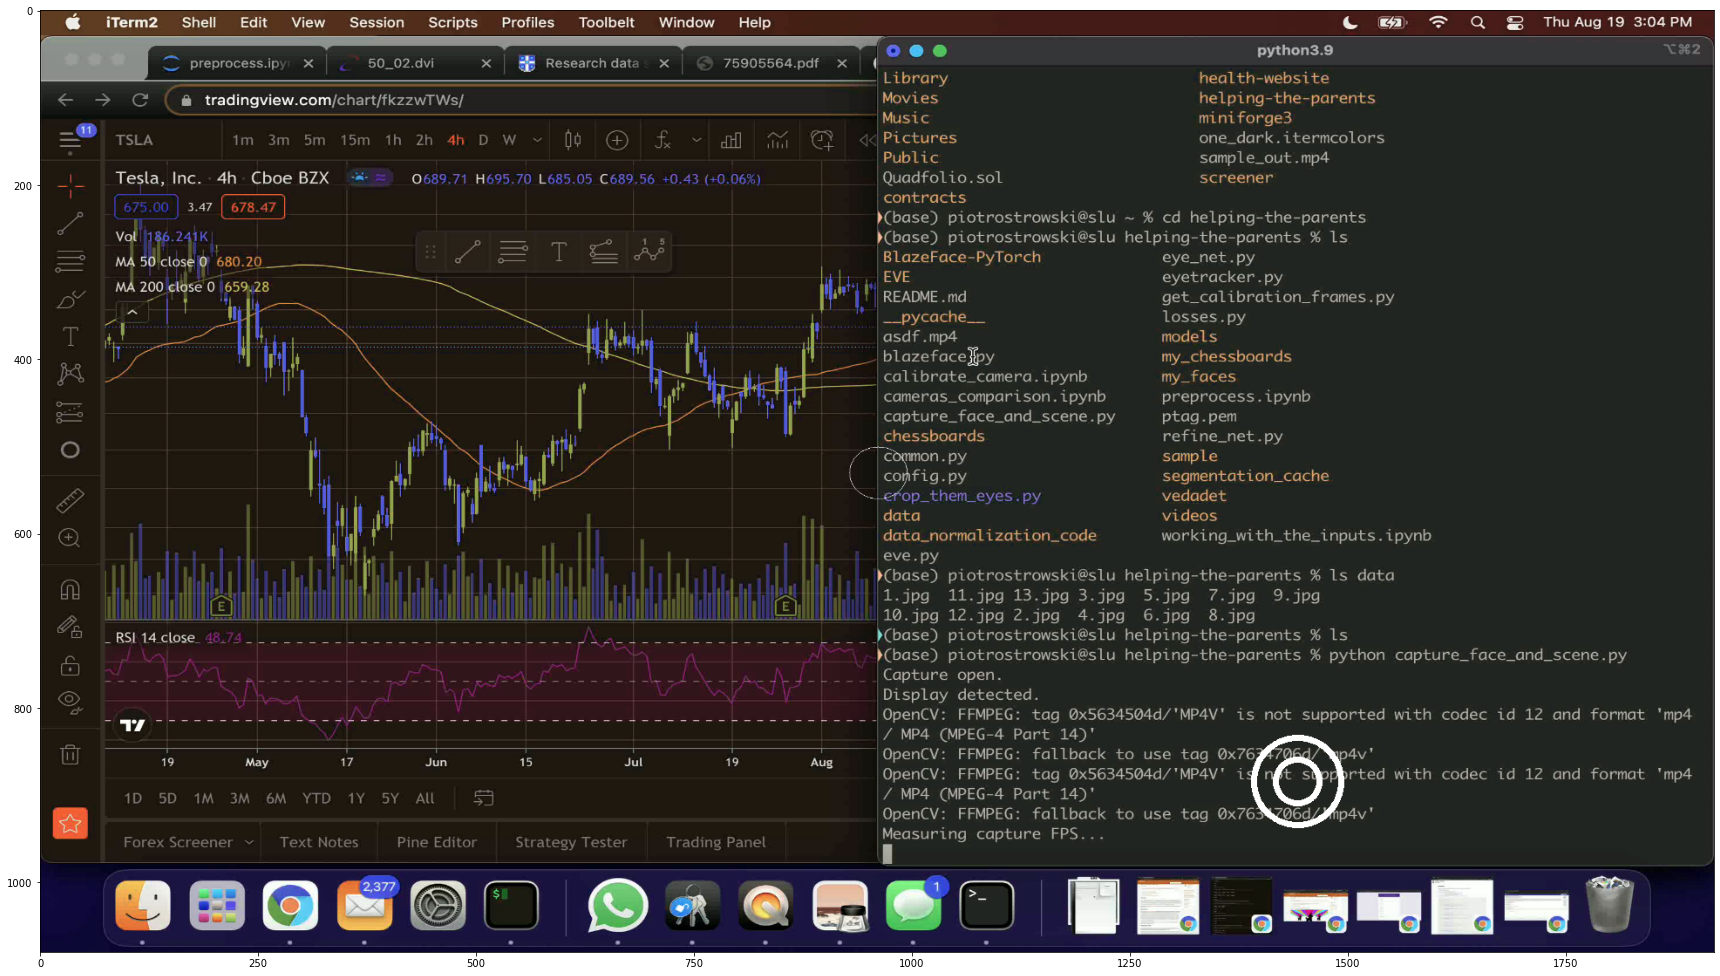

In [104]:
plt.figure(figsize=(30, 20))
plt.imshow(frame)

In [1]:
from preprocess import get_frames_and_timestamps

In [2]:
from multiprocessing import Pool

In [10]:
with Pool(10) as p:
    [(face_frames, timestamps)] = p.map(get_frames_and_timestamps, 
                                      ['./data/face.mp4',])

Parsing frames...
......................................................................................................................................................
Done!


In [84]:
s = """
 CROCS SUSTAINABILITY
 MEDIA
NO.
MEDIA
LINK
1
T-ONLINE
https://www.t-online.de
 2
MSN.DE
 https://www.msn.com/de-de
 3
YAHOO
https://de.yahoo.com/?guccounter=1
4
BILD
 https://www.bild.de/
5
N-TV
 https://www.n-tv.de
6
FOCUS ONLINE
 https://www.focus.de
7
ZEIT ONLINE
 https://www.zeit.de/index
8
STERN
 https://www.stern.de
9
NEWS.AT
  https://www.news.at
 10
NZZ.CH
https://www.nzz.ch
11
 WELT
 https://www.welt.de
12
FAZ
 https://www.faz.net/aktuell/
13
SZ
 https://www.sueddeutsche.de
14
HIGHSNOBIETY
 https://www.highsnobiety.com
15
GQ
 https://www.gq-magazin.de
16
ELLE
 https://www.elle.de
17
VOGUE
 https://www.vogue.de
18
NYLON
 https://nylonmag.de
19
GLAMOUR
 https://www.glamour.de
20
ESQUIRE
 https://www.esquire.de
21
NOIZZ.DE
  https://noizz.de
 22
GALA
https://www.gala.de
23
INTOUCH
 https://www.wunderweib.de
24
BUNTE
 http://bunte.de
25
INSTYLE
 https://www.instyle.de
26
GRAZIA
 https://www.grazia-magazin.de
                                     
"""

In [87]:
l = s.split('\n')

In [88]:
l = [i.replace(' ', '') for i in l]

In [90]:
l = [i for i in l if i]

In [92]:
import pandas as pd

In [98]:
lst = l

In [101]:
df = pd.DataFrame([lst[i:i+3] for i in range(0, len(lst), 3)])

In [104]:
!pip install openpyxl

     |████████████████████████████████| 243 kB 5.9 MB/s eta 0:00:01


In [105]:
df.to_excel('sheet.xlsx', sheet_name='Sheet1')

In [12]:
for i in face_frames[:2]:
    print(i.shape)

(720, 1280, 3)
(720, 1280, 3)


In [14]:
import torch

In [39]:
t1 = torch.Tensor([True]).unsqueeze(0)
t2 = torch.Tensor([False]).unsqueeze(0)

In [40]:
t1.shape

torch.Size([1, 1])

In [55]:
l = []

In [72]:
l.append(single.numpy())

In [48]:
[single] = inp['camera_transformation'][:, 0]

In [71]:
inp['camera_transformation'].shape

torch.Size([1, 30, 4, 4])

In [83]:
np.concatenate([[], [1]])

array([1.])

In [43]:
inp['left_o_validity'].

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True]])

In [42]:
torch.cat([t1, t2], dim=1)

tensor([[1., 0.]])

In [6]:
from utils import get_sample_input

In [7]:
inp = get_sample_input()

In [26]:
inp['left_o_validity'].shape

torch.Size([1, 30])

In [28]:
inp['left_o_validity']

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True]])

In [138]:
t = torch.Tensor([True, True])

In [7]:
inp['left_eye_patch'].shape

torch.Size([1, 30, 3, 128, 128])

In [1]:
from eyetracker import EyeTracker

In [2]:
et = EyeTracker()

Models loaded.
Calibration images loaded.


In [23]:
et.initialize_inputs()

Input dict initialized.


In [24]:
et.fill_inputs('./data/face.mp4', './data/scene.mp4')

Parsing frames...
..........
Done!
Parsing frames...
..........
Done!


In [25]:
et.preprocess_inputs()

In [26]:
inp['millimeters_per_pixel'].shape

torch.Size([1, 30, 2])

In [27]:
et.inputs['millimeters_per_pixel'].shape

torch.Size([1, 10, 2])

In [28]:
inp['screen_frame'].shape

torch.Size([1, 30, 3, 72, 128])

In [29]:
et.inputs['screen_frame'].shape

torch.Size([1, 1, 10, 3, 72, 128])